In [1]:
import numpy as np 
import pandas as pd

import glob

import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import pearsonr

import seaborn as sns

import tensorflow as tf

import random

import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

2025-07-18 21:33:00.299272: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752874380.578146      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752874380.663827      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
files = glob.glob(r"/kaggle/input/eeg-processed-dataset/Model/*.csv")

dfs = [
    df.assign(session_id=f"s_{i:04d}")
    for i, f in enumerate(files)
    for df in [pd.read_csv(f)]
    if not df.empty
]

df = pd.concat(dfs, ignore_index=True)

df['label'] = df['label'].replace(2, 1)

In [3]:
df.head()

,EEG FP1-REF_mean,EEG FP1-REF_std,EEG FP1-REF_energy,EEG FP1-REF_max,EEG FP1-REF_min,EEG FP1-REF_hjorth_activity,EEG FP1-REF_hjorth_mobility,EEG FP1-REF_hjorth_complexity,EEG FP2-REF_mean,EEG FP2-REF_std,...,EEG 32-REF_hjorth_activity,EEG 32-REF_hjorth_mobility,EEG 32-REF_hjorth_complexity,Time,Heart_Rate,label,seizure_in_seconds,patient_id,Resp_BPM,session_id
0,-6.505065e-07,0.000009,1.852940e-07,0.000020,-0.000030,7.369443e-11,0.130930,5.299173,-6.862302e-07,0.000015,...,7.499208e-12,0.430281,1.874318,02-07-2025 00:00:00,118.552413,1,0.0,aaaaaajy_s003_t001,36.0,s_0000
1,-4.467394e-08,0.000010,2.612094e-07,0.000021,-0.000042,1.044818e-10,0.117867,5.508765,-6.052508e-07,0.000016,...,6.946338e-12,0.457987,1.733766,02-07-2025 00:00:05,95.703956,1,0.0,aaaaaajy_s003_t001,30.0,s_0000
2,8.434793e-07,0.000012,3.743722e-07,0.000030,-0.000042,1.490374e-10,0.104164,6.416122,1.609395e-06,0.000021,...,7.606872e-12,0.448561,1.768384,02-07-2025 00:00:10,98.360656,1,0.0,aaaaaajy_s003_t001,42.0,s_0000
3,-1.692641e-07,0.000010,2.621512e-07,0.000030,-0.000034,1.048318e-10,0.121807,5.675471,4.842201e-07,0.000022,...,7.244832e-12,0.462141,1.689042,02-07-2025 00:00:15,99.709182,1,0.0,aaaaaajy_s003_t001,36.0,s_0000
4,-6.583482e-07,0.000006,1.022979e-07,0.000014,-0.000018,4.048573e-11,0.185331,3.915474,-1.109929e-06,0.000014,...,6.955454e-12,0.469231,1.676881,02-07-2025 00:00:20,109.444670,1,0.0,aaaaaajy_s003_t001,30.0,s_0000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1396 entries, 0 to 1395
Columns: 263 entries, EEG FP1-REF_mean to session_id
dtypes: float64(259), int64(1), object(3)
memory usage: 2.8+ MB


In [5]:
columns_to_consider = df.columns[:-6]

parent_categories = set(col.split('_')[0] for col in columns_to_consider if '_' in col)


l = len(parent_categories)
i=0

# Print them
for category in sorted(parent_categories):
    if i!=l-1:
        print(category, end=', ')
        i+=1
    else:
        print(category)

EEG 31-REF, EEG 32-REF, EEG A1-REF, EEG A2-REF, EEG C3-REF, EEG C4-REF, EEG CZ-REF, EEG EKG-REF, EEG F3-REF, EEG F4-REF, EEG F7-REF, EEG F8-REF, EEG FP1-REF, EEG FP2-REF, EEG FZ-REF, EEG LUC-REF, EEG O1-REF, EEG O2-REF, EEG P3-REF, EEG P4-REF, EEG PZ-REF, EEG RESP1-REF, EEG RESP2-REF, EEG RLC-REF, EEG SP1-REF, EEG SP2-REF, EEG T1-REF, EEG T2-REF, EEG T3-REF, EEG T4-REF, EEG T5-REF, EEG T6-REF


In [6]:
# Correct prefixes based on your columns' actual format
selected_prefixes = ["EEG EKG-REF", "EEG RESP1-REF", "EEG RESP2-REF", "SyntheticEMG"]

# Filter columns by prefixes
selected_columns = [col for col in df.columns if any(col.startswith(prefix) for prefix in selected_prefixes)]
selected_columns.append("label")  # Add the label column

# Create a filtered copy of the DataFrame
filtered_df = df[selected_columns].copy()

# Output the shape and preview the data
print("Filtered DataFrame shape:", filtered_df.shape)
filtered_df.head()

Filtered DataFrame shape: (1396, 25)


,EEG EKG-REF_mean,EEG EKG-REF_std,EEG EKG-REF_energy,EEG EKG-REF_max,EEG EKG-REF_min,EEG EKG-REF_hjorth_activity,EEG EKG-REF_hjorth_mobility,EEG EKG-REF_hjorth_complexity,EEG RESP1-REF_mean,EEG RESP1-REF_std,...,EEG RESP1-REF_hjorth_complexity,EEG RESP2-REF_mean,EEG RESP2-REF_std,EEG RESP2-REF_energy,EEG RESP2-REF_max,EEG RESP2-REF_min,EEG RESP2-REF_hjorth_activity,EEG RESP2-REF_hjorth_mobility,EEG RESP2-REF_hjorth_complexity,label
0,1.055455e-07,0.000014,5.245812e-07,0.000057,-0.000075,2.098213e-10,0.274601,1.864951,-1.525902e-07,0.000009,...,4.293078,4.856511e-07,0.000009,2.071653e-07,0.000027,-0.000024,8.263026e-11,0.135689,4.468577,1
1,1.096757e-07,0.000016,6.392248e-07,0.000057,-0.000075,2.556779e-10,0.271260,1.964610,-4.668456e-07,0.000009,...,3.723687,6.933888e-08,0.000010,2.354540e-07,0.000036,-0.000027,9.417678e-11,0.155976,3.792206,1
2,-6.582874e-07,0.000017,7.400824e-07,0.000055,-0.000077,2.955996e-10,0.250114,2.343401,2.041296e-07,0.000010,...,3.891552,-7.599649e-07,0.000012,3.580935e-07,0.000036,-0.000027,1.426599e-10,0.142978,4.283225,1
3,-1.426709e-07,0.000016,6.114257e-07,0.000055,-0.000077,2.445499e-10,0.260325,2.331303,3.682135e-07,0.000009,...,4.104261,-1.335846e-07,0.000011,2.958686e-07,0.000035,-0.000025,1.183296e-10,0.154048,4.133356,1
4,-5.228544e-08,0.000013,4.339449e-07,0.000055,-0.000061,1.735752e-10,0.285990,2.052733,-6.029663e-07,0.000009,...,4.375568,1.811244e-08,0.000008,1.483772e-07,0.000028,-0.000022,5.935053e-11,0.202945,3.103438,1


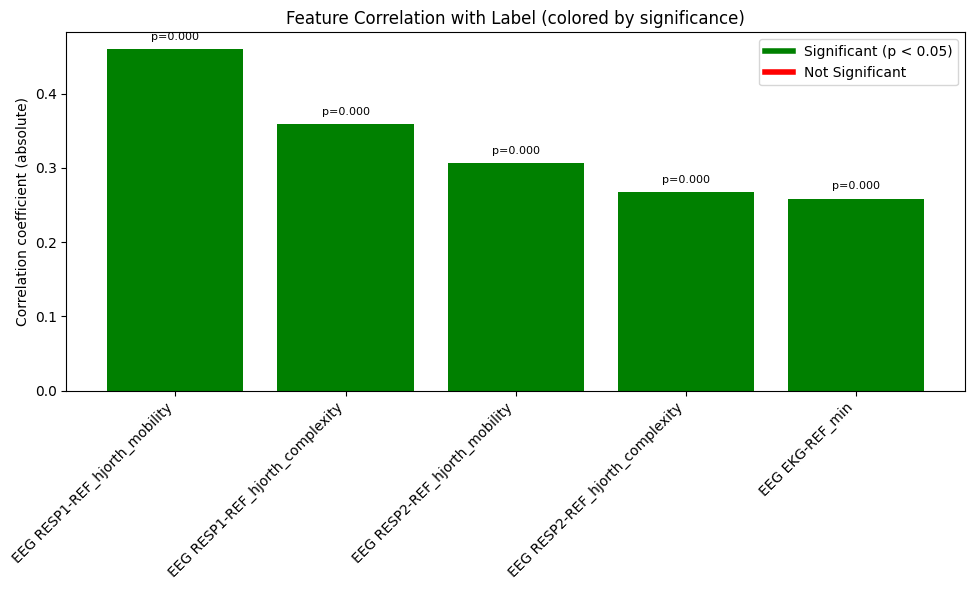

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import pearsonr

# Calculate correlations and p-values
correlations = []
for col in filtered_df.columns:
    if col != "label":
        corr, pval = pearsonr(filtered_df[col], filtered_df["label"])
        correlations.append({
            "Feature": col,
            "Correlation": abs(corr),
            "P-value": pval,
            "Significant": pval < 0.05
        })

# Convert to DataFrame and sort
corr_df = pd.DataFrame(correlations)
corr_df = corr_df.sort_values(by="Correlation", ascending=False)

# Apply correlation threshold filter (e.g., keep correlations >= 0.2)
threshold = 0.2
corr_df = corr_df[(corr_df["Correlation"] >= threshold) & (corr_df["Significant"])]

# Plot
plt.figure(figsize=(10, 6))
bars = plt.bar(
    corr_df["Feature"],
    corr_df["Correlation"],
    color=["green" if sig else "red" for sig in corr_df["Significant"]]
)

# Annotate p-values
for bar, pval in zip(bars, corr_df["P-value"]):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.01,
        f"p={pval:.3f}",
        ha='center',
        va='bottom',
        fontsize=8
    )

plt.title("Feature Correlation with Label (colored by significance)")
plt.ylabel("Correlation coefficient (absolute)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.legend(handles=[
    plt.Line2D([0], [0], color='green', lw=4, label='Significant (p < 0.05)'),
    plt.Line2D([0], [0], color='red', lw=4, label='Not Significant')
])
plt.show()

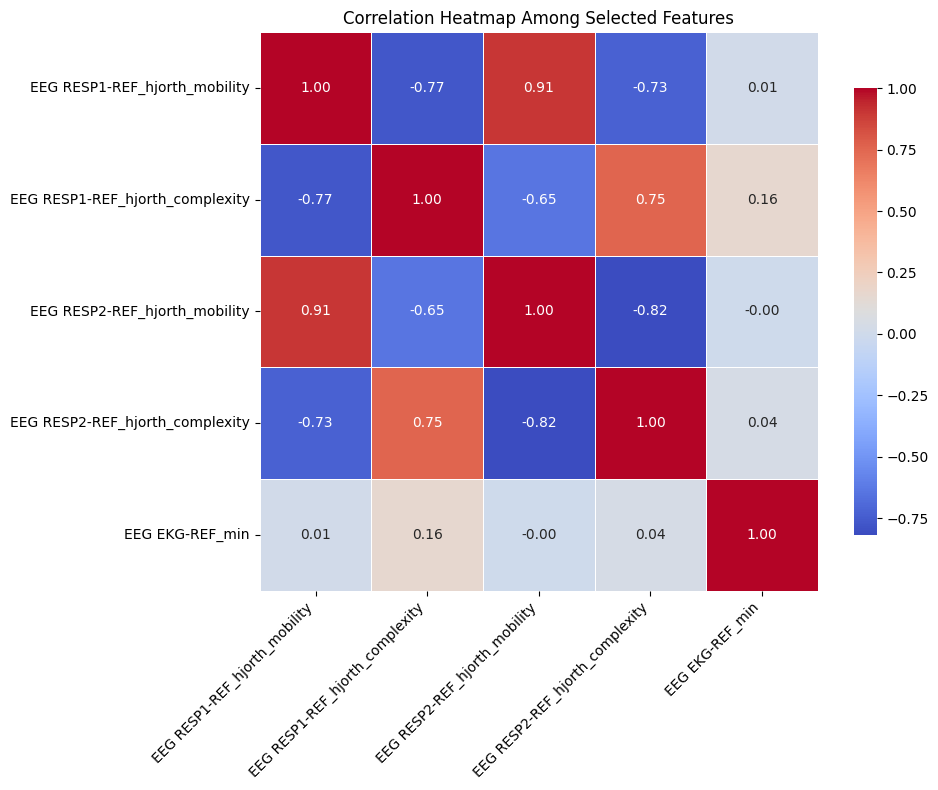

In [8]:
import seaborn as sns

# Get the list of filtered feature names (after correlation + significance filtering)
selected_features = corr_df["Feature"].tolist()

# Subset the DataFrame to include only those features
filtered_feature_df = filtered_df[selected_features]

# Compute correlation matrix among selected features
selected_corr_matrix = filtered_feature_df.corr(method='pearson')

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    selected_corr_matrix,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    square=True,
    cbar_kws={"shrink": .8},
    linewidths=0.5
)
plt.title("Correlation Heatmap Among Selected Features")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [9]:
# Store significant features in a list
significant_features = corr_df[corr_df["Significant"]]["Feature"].tolist()
print(significant_features)

significant_features= ['EEG RESP1-REF_hjorth_mobility',
 'EEG RESP2-REF_hjorth_mobility',
 'EEG EKG-REF_min'] 

['EEG RESP1-REF_hjorth_mobility', 'EEG RESP1-REF_hjorth_complexity', 'EEG RESP2-REF_hjorth_mobility', 'EEG RESP2-REF_hjorth_complexity', 'EEG EKG-REF_min']


In [10]:
sequence_length = 3

X_seqs, y_seqs = [], []

for session in df['session_id'].unique():
    session_df = df[df['session_id'] == session].reset_index(drop=True)
    for i in range(len(session_df) - sequence_length + 1):
        window = session_df.loc[i:i+sequence_length-1, significant_features].values
        label = session_df.loc[i+sequence_length-1, 'label']  # or majority
        X_seqs.append(window)
        y_seqs.append(label)

X_seq_array = np.array(X_seqs)
y_seq_array = np.array(y_seqs)


--- Random Forest (Tuned) ---
Best Params: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None}
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       232
           1       0.85      0.83      0.84        41

    accuracy                           0.95       273
   macro avg       0.91      0.90      0.91       273
weighted avg       0.95      0.95      0.95       273



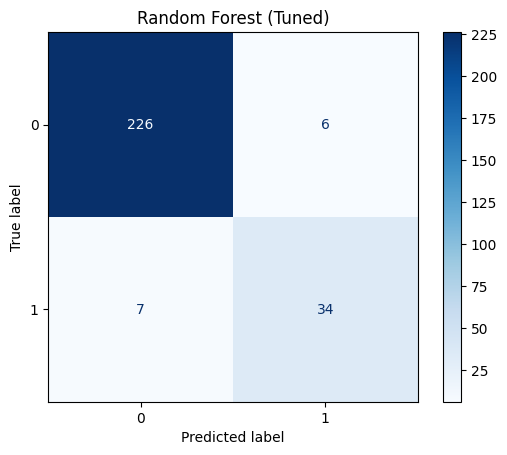


--- XGBoost (Tuned) ---
Best Params: {'subsample': 0.7, 'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.9}
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       232
           1       0.85      0.80      0.83        41

    accuracy                           0.95       273
   macro avg       0.91      0.89      0.90       273
weighted avg       0.95      0.95      0.95       273



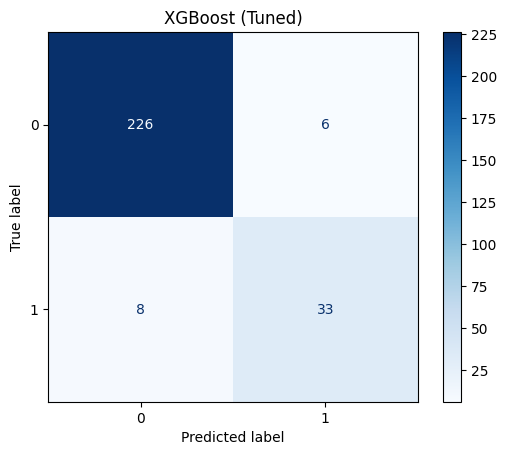


--- CatBoost (Tuned) ---
Best Params: {'learning_rate': 0.05, 'l2_leaf_reg': 5, 'iterations': 200, 'depth': 8}
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       232
           1       0.86      0.88      0.87        41

    accuracy                           0.96       273
   macro avg       0.92      0.93      0.92       273
weighted avg       0.96      0.96      0.96       273



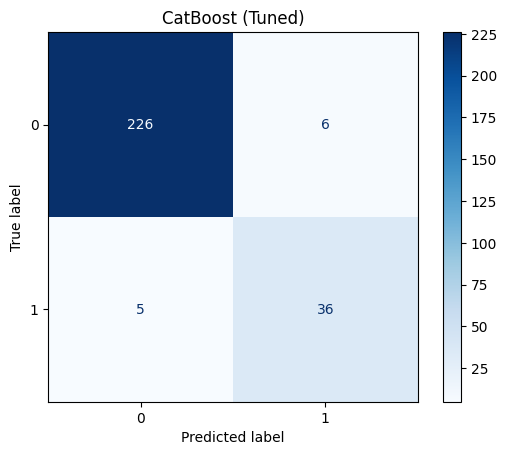

In [11]:
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from catboost import CatBoostClassifier
import xgboost as xgb
import matplotlib.pyplot as plt
import numpy as np

# Flatten the sequence input
X_flat = X_seq_array.reshape((X_seq_array.shape[0], -1))
X_train, X_test, y_train, y_test = train_test_split(X_flat, y_seq_array, test_size=0.2, random_state=42)

def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")
    plt.title(title)
    plt.show()

def train_rf_tuned():
    print("\n--- Random Forest (Tuned) ---")
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
        'max_features': ['sqrt', 'log2'],
    }
    rf = RandomForestClassifier(class_weight='balanced', random_state=42)
    search = RandomizedSearchCV(rf, param_distributions=param_grid, n_iter=10, scoring='balanced_accuracy', cv=3, n_jobs=-1, random_state=42)
    search.fit(X_train, y_train)
    best_rf = search.best_estimator_
    print("Best Params:", search.best_params_)
    y_pred = best_rf.predict(X_test)
    print(classification_report(y_test, y_pred))
    plot_cm(y_test, y_pred, "Random Forest (Tuned)")
    return best_rf

def train_xgb_tuned():
    print("\n--- XGBoost (Tuned) ---")
    param_dist = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 6, 10],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.7, 0.9, 1.0],
        'colsample_bytree': [0.7, 0.9, 1.0]
    }
    xgb_model = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False,
                                  scale_pos_weight=(sum(y_train == 0) / sum(y_train == 1)),
                                  eval_metric='logloss', random_state=42)
    search = RandomizedSearchCV(xgb_model, param_distributions=param_dist, n_iter=10, scoring='balanced_accuracy', cv=3, n_jobs=-1, random_state=42)
    search.fit(X_train, y_train)
    best_xgb = search.best_estimator_
    print("Best Params:", search.best_params_)
    y_pred = best_xgb.predict(X_test)
    print(classification_report(y_test, y_pred))
    plot_cm(y_test, y_pred, "XGBoost (Tuned)")
    return best_xgb

def train_catboost_tuned():
    print("\n--- CatBoost (Tuned) ---")
    param_dist = {
        'iterations': [100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1],
        'depth': [4, 6, 8],
        'l2_leaf_reg': [1, 3, 5]
    }
    cat_model = CatBoostClassifier(loss_function='Logloss', eval_metric='F1',
                                   class_weights=[1, sum(y_train == 0) / sum(y_train == 1)],
                                   verbose=0, random_seed=42)
    search = RandomizedSearchCV(cat_model, param_distributions=param_dist, n_iter=10, scoring='balanced_accuracy', cv=3, n_jobs=-1, random_state=42)
    search.fit(X_train, y_train)
    best_cat = search.best_estimator_
    print("Best Params:", search.best_params_)
    y_pred = best_cat.predict(X_test)
    print(classification_report(y_test, y_pred))
    plot_cm(y_test, y_pred, "CatBoost (Tuned)")
    return best_cat

# Run them
best_rf = train_rf_tuned()
best_xgb = train_xgb_tuned()
best_cat = train_catboost_tuned()

In [12]:
selected_features_dl = selected_columns.copy()
selected_features_dl.remove("label")

In [13]:
sequence_length = 3

X_seqs, y_seqs = [], []

for session in df['session_id'].unique():
    session_df = df[df['session_id'] == session].reset_index(drop=True)
    for i in range(len(session_df) - sequence_length + 1):
        window = session_df.loc[i:i+sequence_length-1, selected_features_dl].values
        label = session_df.loc[i+sequence_length-1, 'label']
        X_seqs.append(window)
        y_seqs.append(label)

X_seq_array = np.array(X_seqs)
y_seq_array = np.array(y_seqs)

2025-07-18 21:33:44.395355: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)



Training LSTM model
Epoch 1/20
35/35 - 5s - 145ms/step - accuracy: 0.6575 - auc: 0.7141 - loss: 0.6452 - val_accuracy: 0.8132 - val_auc: 0.9157 - val_loss: 0.5802
Epoch 2/20
35/35 - 0s - 8ms/step - accuracy: 0.6961 - auc: 0.8473 - loss: 0.5447 - val_accuracy: 0.8864 - val_auc: 0.9186 - val_loss: 0.4190
Epoch 3/20
35/35 - 0s - 8ms/step - accuracy: 0.8062 - auc: 0.8632 - loss: 0.4742 - val_accuracy: 0.8352 - val_auc: 0.9212 - val_loss: 0.4155
Epoch 4/20
35/35 - 0s - 8ms/step - accuracy: 0.7493 - auc: 0.8647 - loss: 0.4378 - val_accuracy: 0.8425 - val_auc: 0.9225 - val_loss: 0.3789
Epoch 5/20
35/35 - 0s - 8ms/step - accuracy: 0.8007 - auc: 0.8777 - loss: 0.4017 - val_accuracy: 0.8645 - val_auc: 0.9354 - val_loss: 0.3104
Epoch 6/20
35/35 - 0s - 8ms/step - accuracy: 0.8026 - auc: 0.9030 - loss: 0.3821 - val_accuracy: 0.8681 - val_auc: 0.9398 - val_loss: 0.3286
Epoch 7/20
35/35 - 0s - 7ms/step - accuracy: 0.8118 - auc: 0.9009 - loss: 0.3690 - val_accuracy: 0.8352 - val_auc: 0.9431 - val_los

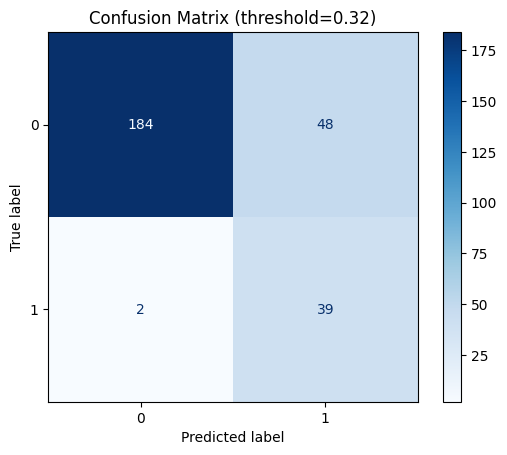

              precision    recall  f1-score   support

           0     0.9892    0.7931    0.8804       232
           1     0.4483    0.9512    0.6094        41

    accuracy                         0.8168       273
   macro avg     0.7188    0.8722    0.7449       273
weighted avg     0.9080    0.8168    0.8397       273


Training BiLSTM model
Epoch 1/20
35/35 - 7s - 191ms/step - accuracy: 0.5914 - auc_1: 0.7669 - loss: 0.6241 - val_accuracy: 0.8388 - val_auc_1: 0.9162 - val_loss: 0.5413
Epoch 2/20
35/35 - 0s - 9ms/step - accuracy: 0.7805 - auc_1: 0.8633 - loss: 0.5181 - val_accuracy: 0.8462 - val_auc_1: 0.9229 - val_loss: 0.4288
Epoch 3/20
35/35 - 0s - 8ms/step - accuracy: 0.8062 - auc_1: 0.8765 - loss: 0.4290 - val_accuracy: 0.8681 - val_auc_1: 0.9436 - val_loss: 0.3200
Epoch 4/20
35/35 - 0s - 8ms/step - accuracy: 0.8136 - auc_1: 0.9057 - loss: 0.3789 - val_accuracy: 0.8059 - val_auc_1: 0.9404 - val_loss: 0.4119
Epoch 5/20
35/35 - 0s - 8ms/step - accuracy: 0.8292 - auc_1: 0.9209 

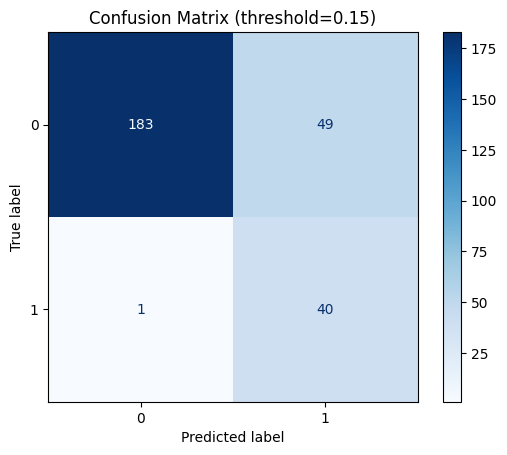

              precision    recall  f1-score   support

           0     0.9946    0.7888    0.8798       232
           1     0.4494    0.9756    0.6154        41

    accuracy                         0.8168       273
   macro avg     0.7220    0.8822    0.7476       273
weighted avg     0.9127    0.8168    0.8401       273



In [14]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import roc_curve, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import matplotlib.pyplot as plt

# Model 1: LSTM
def create_lstm_model(sequence_length, num_features):
    model = models.Sequential([
        layers.Input(shape=(sequence_length, num_features)),
        layers.LSTM(64),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.AUC()])
    return model

# Model 2: Bidirectional LSTM
def create_bilstm_model(sequence_length, num_features):
    model = models.Sequential([
        layers.Input(shape=(sequence_length, num_features)),
        layers.Bidirectional(layers.LSTM(64)),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.AUC()])
    return model

# Training function
def train_model(model, X_train, y_train, X_val, y_val,
                class_weight=None, epochs=20, batch_size=32):
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        class_weight=class_weight,
        verbose=2
    )
    return history

# Evaluation function
def predict_and_evaluate(model, X_test, y_test, threshold=0.5, plot_cm=True):
    y_pred_probs = model.predict(X_test).ravel()

    if threshold == "best":
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
        J = tpr - fpr
        ix = np.argmax(J)
        threshold = thresholds[ix]
        print(f"Best threshold found: {threshold:.4f}")

    y_pred = (y_pred_probs > threshold).astype(int)

    if plot_cm:
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap="Blues")
        plt.title(f"Confusion Matrix (threshold={threshold:.2f})")
        plt.show()

    print(classification_report(y_test, y_pred, digits=4))
    return threshold, y_pred

# Assume X_seq_array, y_seq_array, and significant_features are defined
sequence_length = X_seq_array.shape[1]
num_features = len(selected_features_dl)

# Create models
lstm_model = create_lstm_model(sequence_length, num_features)
bilstm_model = create_bilstm_model(sequence_length, num_features)

dl_models = [("LSTM", lstm_model), ("BiLSTM", bilstm_model)]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_seq_array, y_seq_array, test_size=0.2, random_state=42
)

# Compute class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced', classes=np.unique(y_train), y=y_train
)
class_weight_dict = dict(enumerate(class_weights))

# Train and evaluate each model
for name, model in dl_models:
    print(f"\nTraining {name} model")
    train_model(model, X_train, y_train, X_test, y_test,
                class_weight=class_weight_dict, epochs=20)

    print(f"\nEvaluating {name} model")
    predict_and_evaluate(model, X_test, y_test, threshold="best")

In [15]:
import pickle 

# Save the model to a file
with open('seizure_detection_model.pkl', 'wb') as file:
    pickle.dump(best_cat, file)

print("Model saved successfully!")

Model saved successfully!
